In [1]:
"""
Isotope Micro-Mapping Pipeline
-----------------------------------------------

What this script does
- Builds a controlled vocabulary of "micro" labels from an input CSV
- Uses an LLM to softly map each paper to a canonical micro label
- Applies heuristic refinement for unmapped items ("other_micro")
- Derives Stack/Area from Micro where helpful
- Exports:
  • Isotope_enriched_papers.csv      (paper rows + MicroCanonical etc.)
  • Isotope_nodes_decision_tree.csv  (graph nodes)
  • Isotope_edges_decision_tree.csv  (graph edges)
  • Isotope_classification.json      (classification payload)

Input provenance
- The input CSV is produced by mynotebook:
  **Isotope Analysis/isotopes_analyse.ipynb**
  (Adjust the --input path if your CSV lives elsewhere.)

Safety & secrets
- This script expects OPENAI_API_KEY in your environment (loadable via `.env`).
- Do NOT commit your `.env` file. Add it to `.gitignore`.

Usage (examples)
- Default run:
    python isotope_pipeline.py
- Limit to first 500 papers:
    python isotope_pipeline.py --max-papers 500
- Dry-run (skip LLM; everything becomes 'other_micro'):
    python isotope_pipeline.py --dry-run

"""

import os, json, time, re, argparse, random
import pandas as pd
from collections import defaultdict
from dotenv import load_dotenv

try:
    from openai import OpenAI
except ImportError:
    raise RuntimeError("OpenAI SDK not found. Install with: pip install 'openai>=1.0'")

# ======== Configuration ========
MODEL       = "gpt-4o-mini"   # you may swap to a stronger model if needed
TEMPERATURE = 0.1
RETRIES     = 3
RETRY_SLEEP = 15

TOP_MICROS_PER_STACK = 20
MIN_MICRO_FREQ       = 2
ALLOW_OTHER_MICRO    = True

VERBOSE = True
DRY_RUN = False
MAX_STACKS = None
MAX_PAPERS_TOTAL = None

GLOBAL_STACK_NAME = "GLOBAL"

# ---- Input/Output ----
# NOTE: This CSV is created by: Isotope Analysis/isotopes_analyse.ipynb
DEFAULT_INPUT_CSV = "works_2023-2025__Quanten_Research__LLM_FILTERED.csv"

ENRICHED_PAPERS_CSV = "Isotope_enriched_papers.csv"
NODES_CSV           = "Isotope_nodes_decision_tree.csv"
EDGES_CSV           = "Isotope_edges_decision_tree.csv"
CLASSIFICATION_JSON = "Isotope_classification.json"

CONTROLLED_VOCAB_JSON = "Isotope_controlled_micro_vocab.json"
LLM_CLASS_JSON        = "Isotope_classification_canonical.json"

# --- Progress / Logging ---
QUIET_PROGRESS = True   # True = single-line progress bar; False = print messages
USE_TQDM       = False  # True = tqdm progress bar (if installed)

try:
    from tqdm import tqdm
except Exception:
    tqdm = None

def print_once(msg: str) -> None:
    """Print a message unless quiet progress mode is enabled."""
    if not QUIET_PROGRESS:
        print(msg)

def progress_update(done: int, total: int, prefix: str = "⏳ Progress") -> None:
    """Console-friendly single-line progress bar."""
    pct = 0 if total == 0 else int(done * 100 / total)
    bar = f"{prefix}: {pct}%  ({done}/{total})"
    print("\r" + bar, end="", flush=True)

def progress_done() -> None:
    """Finish the single-line progress bar."""
    print()

# ========================================
load_dotenv()
api_key = os.getenv("OPENAI_API_KEY", "").strip()
if not api_key:
    raise RuntimeError(
        "OPENAI_API_KEY is not set. Create a `.env` file with:\n"
        "OPENAI_API_KEY=sk-...\n"
        "and ensure `.env` is in your .gitignore (do not commit secrets)."
    )
client = OpenAI(api_key=api_key)

# ---------- Utilities ----------
def pick_col(df: pd.DataFrame, candidates, required=True, default=None):
    """Return the first column name that exists in df from a list of candidates."""
    for c in candidates:
        if c in df.columns:
            return c
    if required:
        raise ValueError(f"None of the expected columns were found: {candidates}")
    return default

def norm_space(s):
    """Normalize whitespace; return empty string for non-strings."""
    if not isinstance(s, str):
        return ""
    return re.sub(r"\s+", " ", s.strip())

def slug(s):
    """Stable id-friendly slug (lowercase, underscores)."""
    s = str(s).strip().lower()
    s = s.replace("::", "__")
    s = re.sub(r"\s+", "_", s)
    s = re.sub(r"[^a-z0-9_\-:]", "", s)
    return s

def _sleep_with_jitter(base):
    """Backoff helper with jitter to be gentle on APIs."""
    time.sleep(base + random.uniform(0, base/2))

# --- Synonym/regex normalization for micro terms ---
SYN_REGEX = [
    (re.compile(r"\bnv[\s\-]?cent(er|re)s?\b", re.I), "nv centers"),
    (re.compile(r"\bnitrogen\s+vacancy\b", re.I),     "nv centers"),
    (re.compile(r"\bdiamond\s+magnetomet(er|ry)\b", re.I), "magnetometry"),
    (re.compile(r"\bspin\s*read[- ]?out\b", re.I),    "spin readout"),
    (re.compile(r"\bspin\s*sens(ing|or)\b", re.I),    "spin sensing"),
    (re.compile(r"\bquantum\s+sensor(s)?\b", re.I),   "quantum sensor"),
    (re.compile(r"\bcolor\s*centers?\b", re.I),       "color centers"),
    (re.compile(r"\bphotonic(s)?\b", re.I),           "photonic"),
    (re.compile(r"\btransmon\s+qubit(s)?\b", re.I),   "transmon"),
    (re.compile(r"\brydberg\b", re.I),                "rydberg"),
    (re.compile(r"\bion\s+trap(s)?\b|\btrapped\s+ions?\b|\bpaul\s+trap\b", re.I), "ion trap"),
    (re.compile(r"\batomic\s+clock\b", re.I),         "atomic clock"),
    (re.compile(r"\bspin\s+qubit(s)?\b", re.I),       "spin qubit"),
]

def normalize_phrase(s: str) -> str:
    """Normalize a free-text phrase for soft matching."""
    t = norm_space(s).lower()
    for pat, repl in SYN_REGEX:
        t = pat.sub(repl, t)
    t = re.sub(r"[^a-z0-9\s\-]", " ", t)
    t = re.sub(r"\s+", " ", t).strip()
    return t

# Lightweight similarity: Jaccard over tokens + prefix bonus
def soft_similarity(a: str, b: str) -> float:
    a = normalize_phrase(a)
    b = normalize_phrase(b)
    if not a or not b:
        return 0.0
    A = set(a.split())
    B = set(b.split())
    j = len(A & B) / max(1, len(A | B))
    prefix = 0.15 if a[:6] == b[:6] else 0.0
    return j + prefix

def best_soft_match(cand: str, allowed: list, thresh: float = 0.35):
    """Return the best allowed label if above threshold; otherwise None."""
    best, score = None, 0.0
    for al in allowed:
        s = soft_similarity(cand, al)
        if s > score:
            best, score = al, s
    return best if score >= thresh else None

# ---------- 1) Build vocabulary from CSV ----------
SEED_MICROS_GLOBAL = [
    "nv centers","magnetometry","spin readout","spin sensing",
    "quantum sensor","transmon","photonic","ion trap",
    "rydberg","atomic clock","spin qubit","color centers"
]

def build_vocab_from_csv(csv_path: str):
    """
    Create a per-stack micro vocabulary from the input CSV.
    Falls back to a GLOBAL seed vocabulary if micro columns are missing.
    Saves the result to Isotope_controlled_micro_vocab.json.
    """
    print_once(f"📊 Building vocabulary from: {csv_path}")
    df = pd.read_csv(csv_path, low_memory=False)

    col_micro = pick_col(df, ["MicroCanonical", "MicroLabel", "micro"], required=False, default=None)
    col_stack = pick_col(df, ["SubCategory", "stack", "Stack"], required=False, default=None)

    vocab = defaultdict(list)
    if col_micro is None:
        vocab[GLOBAL_STACK_NAME] = list(SEED_MICROS_GLOBAL)
        with open(CONTROLLED_VOCAB_JSON, "w", encoding="utf-8") as f:
            json.dump(vocab, f, indent=2, ensure_ascii=False)
        print_once("ℹ️ No micro column found — using seed vocabulary (GLOBAL).")
        return vocab

    df[col_micro] = df[col_micro].astype(str).map(normalize_phrase)

    if col_stack is None:
        counts = df.groupby(col_micro).size().reset_index(name="n").sort_values("n", ascending=False)
        cand = [(m, int(n)) for m, n in counts.itertuples(index=False)]
        cand = [(m, n) for m, n in cand if n >= MIN_MICRO_FREQ and m not in {"", "unknown", "other_micro"}]
        cand = cand[:TOP_MICROS_PER_STACK]
        vocab[GLOBAL_STACK_NAME] = [m for m, _n in cand] or list(SEED_MICROS_GLOBAL)
    else:
        df[col_stack] = df[col_stack].astype(str).map(norm_space)
        counts = (
            df.groupby([col_stack, col_micro])
              .size()
              .reset_index(name="n")
              .sort_values([col_stack, "n"], ascending=[True, False])
        )
        for stack, grp in counts.groupby(col_stack):
            cand = [(m, int(n)) for _s, m, n in grp.itertuples(index=False)]
            cand = [(m, n) for m, n in cand if n >= MIN_MICRO_FREQ and m not in {"", "unknown", "other_micro"}]
            cand = cand[:TOP_MICROS_PER_STACK]
            vocab[stack] = [m for m, _n in cand]

    if GLOBAL_STACK_NAME not in vocab or not vocab[GLOBAL_STACK_NAME]:
        top_global = (
            df[df[col_micro].ne("other_micro")]
              .groupby(col_micro).size()
              .sort_values(ascending=False)
              .head(TOP_MICROS_PER_STACK)
        )
        vocab[GLOBAL_STACK_NAME] = list(top_global.index) or list(SEED_MICROS_GLOBAL)

    with open(CONTROLLED_VOCAB_JSON, "w", encoding="utf-8") as f:
        json.dump(vocab, f, indent=2, ensure_ascii=False)

    if VERBOSE:
        print_once(f"✅ Vocabulary: {len(vocab)} stack(s), {sum(len(v) for v in vocab.values())} micro terms.")
        print_once(f"💾 Saved control vocabulary: {CONTROLLED_VOCAB_JSON}")
    return vocab

# ---------- 1b) Heuristic: Micro -> Stack -> Area + ordering ----------
MICRO_TO_STACK = {
    # sensing / NV
    "nv centers": "nv_diamond",
    "magnetometry": "nv_diamond",
    "spin readout": "nv_diamond",
    "spin sensing": "nv_diamond",
    "color centers": "nv_diamond",
    "quantum sensor": "nv_diamond",
    "diamond microscopy": "nv_diamond",
    "diamond sensing": "nv_diamond",
    # clocks
    "atomic clock": "neutral_atoms",
    # computing stacks
    "spin qubit": "spin_qubits",
    "rydberg": "neutral_atoms",
    "ion trap": "trapped_ions",
    "photonic": "photonic",
    "transmon": "superconducting",
    # fallback
    "other_micro": "other",
}
STACK_TO_AREA = {
    "nv_diamond": "QuantumSensing",
    "spin_qubits": "QuantumComputing",
    "neutral_atoms": "QuantumComputing",
    "trapped_ions": "QuantumComputing",
    "photonic": "QuantumComputing",
    "superconducting": "QuantumComputing",
    "topological": "QuantumComputing",
    "other": "QuantumTechnology",
}

AREA_ORDER  = ["QuantumSensing", "QuantumComputing", "QuantumCommunication", "QuantumTechnology"]
STACK_ORDER = ["nv_diamond","spin_qubits","trapped_ions","neutral_atoms","photonic","superconducting","topological","other"]

def infer_stack_area_from_micro(micro: str):
    """Given a micro label, infer the stack and area via simple heuristics."""
    m = (micro or "").strip().lower()
    stack = MICRO_TO_STACK.get(m, "other")
    area  = STACK_TO_AREA.get(stack, "QuantumTechnology")
    return stack, area

# ---------- 2) Build LLM prompt ----------
def build_prompt_for_stack(stack_name, allowed_micros, papers):
    """Construct a compact, JSON-only prompt for robust LLM classification."""
    allowed_str = ", ".join(f"'{m}'" for m in allowed_micros)
    other_rule = (
        "Prefer the closest allowed label; use 'other_micro' only if nothing is reasonably close."
        if ALLOW_OTHER_MICRO else
        "Pick the closest allowed label; do NOT use 'other_micro'."
    )
    mapping_hints = (
        "Hints:\n"
        "- 'nv centre', 'nitrogen vacancy' => 'nv centers'\n"
        "- 'diamond magnetometry' => 'magnetometry'\n"
        "- 'spin readout' => 'spin readout'\n"
        "- 'spin sensing'/'spin sensor' => 'spin sensing'\n"
        "- 'quantum sensor(s)' => 'quantum sensor'\n"
    )
    header = (
        "You are an academic curator for quantum-tech literature.\n"
        f"Stack: '{stack_name}'. Allowed canonical Micro labels: [{allowed_str}].\n"
        f"{other_rule}\n"
        + mapping_hints +
        "For EACH paper, return STRICT JSON ONLY:\n"
        "{ \"papers\": [\n"
        "  {\"id\":\"...\", \"micro_canonical\":\"<one_of_allowed_or_other_micro>\",\n"
        "   \"micro_raw\":\"<0-3 words from paper>\", \"confidence\": <0..1> }\n"
        "]}\n"
        "If abstract is missing, decide from title only. NO commentary outside JSON.\n\n"
    )
    body = []
    for p in papers:
        title = (p.get("title") or "")[:3000]
        abstr = (p.get("abstract") or "")[:3000]
        pid   = p.get("id")
        year  = p.get("year","")
        body.append(f"ID: {pid}\nTitle: {title}\nAbstract: {abstr or '(none)'}\nYear: {year}\n")
    return header + "\n---\n".join(body)

# ---------- 3) LLM call ----------
def call_openai_json(prompt):
    """Call the OpenAI chat.completions API with JSON mode and retry logic."""
    for attempt in range(RETRIES):
        try:
            resp = client.chat.completions.create(
                model=MODEL,
                response_format={"type":"json_object"},
                temperature=TEMPERATURE,
                messages=[{"role":"user","content":prompt}],
            )
            return json.loads(resp.choices[0].message.content)
        except Exception as e:
            print_once(f"⚠️ LLM error ({attempt+1}/{RETRIES}): {e}")
            if attempt < RETRIES-1:
                _sleep_with_jitter(RETRY_SLEEP)
            else:
                return {"papers": []}

# ---------- 4) LLM mapping + soft snapping ----------
def canonicalize_micros(df, vocab, chunk_size=6):
    """
    For each stack group, send batched papers to the LLM for classification.
    Then soft-snap raw terms to the allowed set to stabilize labels.
    """
    out = []
    stacks = list(sorted(set(df["stack"].fillna(GLOBAL_STACK_NAME).astype(str))))
    if MAX_STACKS is not None:
        stacks = stacks[:MAX_STACKS]

    total = len(df)
    seen  = 0

    bar = None
    if USE_TQDM and tqdm is not None:
        bar = tqdm(total=total, desc="LLM Mapping", unit="paper")

    global_allowed = set(vocab.get(GLOBAL_STACK_NAME, []))

    for stack in stacks:
        grp = df[df["stack"].fillna(GLOBAL_STACK_NAME).astype(str) == stack]
        allowed = list(vocab.get(stack, [])) or list(global_allowed)

        if not allowed or DRY_RUN:
            for _, r in grp.iterrows():
                out.append({"id": r["id"], "stack": stack,
                            "micro_canonical": "other_micro",
                            "micro_raw": "", "confidence": 0.0})
            seen += len(grp)
            if bar: bar.update(len(grp))
            else:   progress_update(seen, total)
            continue

        rows = grp.to_dict("records")
        for i in range(0, len(rows), chunk_size):
            batch = rows[i:i+chunk_size]
            prompt = build_prompt_for_stack(stack, allowed, batch)
            data   = call_openai_json(prompt)
            items  = data.get("papers", [])

            allowed_lower = [m.lower() for m in allowed]

            for it in items:
                pid     = it.get("id")
                mic_raw = normalize_phrase(str(it.get("micro_raw","")))
                mic_llm = normalize_phrase(str(it.get("micro_canonical","")))
                try:
                    conf = float(it.get("confidence", 0.0))
                except:
                    conf = 0.0

                chosen = mic_llm if mic_llm in allowed_lower else None
                if not chosen and mic_raw:
                    snap = best_soft_match(mic_raw, allowed_lower, thresh=0.33)
                    if snap: chosen = snap
                if not chosen:
                    rec = next((r for r in batch if r["id"] == pid), None)
                    hay = " ".join([normalize_phrase(rec.get("title","")), normalize_phrase(rec.get("abstract",""))]) if rec else ""
                    if hay:
                        snap = best_soft_match(hay, allowed_lower, thresh=0.30)
                        if snap: chosen = snap
                if not chosen:
                    chosen = "other_micro" if ALLOW_OTHER_MICRO else (allowed_lower[0] if allowed_lower else "other_micro")

                out.append({"id": pid, "stack": stack,
                            "micro_canonical": chosen,
                            "micro_raw": mic_raw[:40],
                            "confidence": max(0.0, min(1.0, conf))})

            seen += len(batch)
            if bar: bar.update(len(batch))
            else:   progress_update(seen, total)
            time.sleep(1.0)

    if bar: bar.close()
    else:   progress_done()
    return out

# ---------- 4b) Aggressive refinement pass ONLY for other_micro ----------
# Regex heuristics per micro (examples — extend as needed)
REFINE_PATTERNS = [
    (re.compile(r"\bnv[\s\-]?cent(er|re)s?\b|\bnitrogen\s+vacancy\b", re.I), "nv centers"),
    (re.compile(r"\bmagnetomet(er|ry|er)\b|\bmagnetic\s+sens", re.I), "magnetometry"),
    (re.compile(r"\bspin\s*read[- ]?out\b", re.I), "spin readout"),
    (re.compile(r"\bspin\s+sens(ing|or)\b", re.I), "spin sensing"),
    (re.compile(r"\bquantum\s+sensor(s)?\b", re.I), "quantum sensor"),
    (re.compile(r"\batomic\s+clock\b", re.I), "atomic clock"),
    (re.compile(r"\brydberg\b", re.I), "rydberg"),
    (re.compile(r"\bion\s+trap(s)?\b|\btrapped\s+ions?\b|\bpaul\s+trap\b", re.I), "ion trap"),
    (re.compile(r"\bphotonic(s)?\b|\bwaveguide\b|\binterferometer\b", re.I), "photonic"),
    (re.compile(r"\btransmon\b|\bjosephson\b", re.I), "transmon"),
    (re.compile(r"\bspin\s+qubit(s)?\b|\bsilicon\s+qubit", re.I), "spin qubit"),
    (re.compile(r"\bcolor\s+center(s)?\b", re.I), "color centers"),
]

def refine_others(work_df: pd.DataFrame, mapped_list, vocab):
    """
    Re-map 'other_micro' items using light regex heuristics and
    a global soft match over the combined vocabulary.
    """
    # globally allowed micros
    global_allowed = set(SEED_MICROS_GLOBAL)
    for vals in vocab.values():
        global_allowed.update([str(v).lower() for v in vals])
    allowed = sorted(global_allowed)

    # fast access to mapped objects
    by_id = {m["id"]: m for m in mapped_list}

    changed = 0
    for _, row in work_df.iterrows():
        pid   = str(row["id"])
        entry = by_id.get(pid)
        if not entry:
            continue
        if (entry.get("micro_canonical") or "").lower() != "other_micro":
            continue  # only touch other_micro

        # heuristic on title+abstract
        title = str(row.get("title",""))
        abstr = str(row.get("abstract","") or "")
        hay   = f"{title} || {abstr}"

        new_micro = None
        for pat, lab in REFINE_PATTERNS:
            if pat.search(hay):
                new_micro = lab
                break

        if not new_micro:
            # global soft match (very low threshold)
            guess = best_soft_match(hay, allowed, thresh=0.25)
            if guess:
                new_micro = guess

        if new_micro and new_micro != "other_micro":
            entry["micro_canonical"] = new_micro  # update mapped entry directly
            changed += 1

    print_once(f"🔧 Refinement: reassigned {changed} of {len(mapped_list)} other_micro.")
    return mapped_list

# ---------- 5) Build decision tree ----------
def dedupe_edges(edges):
    """Remove duplicate edges (same source, target, type)."""
    seen, out = set(), []
    for e in edges:
        key = (e["source"], e["target"], e["type"])
        if key not in seen:
            seen.add(key); out.append(e)
    return out

def build_decision_tree_like(work_df: pd.DataFrame, mapped_list):
    """
    Construct a hierarchy: ROOT -> AREA -> STACK -> MICRO -> PAPER.
    Papers can be hidden in downstream visualization if desired.
    """
    class_map = {m["id"]: m for m in mapped_list}
    nodes, edges = [], []

    # Root with a neutral label for downstream plotting
    nodes.append({"id":"ROOT","label":"isotope_analysis","type":"root","year":""})

    tops = defaultdict(list)
    subs = defaultdict(list)
    micros = defaultdict(list)

    for _, p in work_df.iterrows():
        pid   = str(p["id"])
        c     = class_map.get(pid, {})
        area  = (p.get("area") or "").strip() or "QuantumTechnology"
        stack = (p.get("stack") or "").strip() or "other"
        micro = (c.get("micro_canonical") or "other_micro").strip() or "other_micro"

        tops[area].append(pid)
        subs[(area, stack)].append(pid)
        micros[(area, stack, micro)].append(pid)

    # sort keys (stable, human-friendly)
    def area_key(a):
        return (AREA_ORDER.index(a) if a in AREA_ORDER else len(AREA_ORDER), a.lower())
    def stack_key(s):
        return (STACK_ORDER.index(s) if s in STACK_ORDER else len(STACK_ORDER), s.lower())

    # ROOT -> AREA
    for area in sorted(tops.keys(), key=area_key):
        aid = slug(f"AREA::{area}")
        nodes.append({"id":aid,"label":area,"type":"area","year":""})
        edges.append({"source":"ROOT","target":aid,"type":"HIERARCHY"})

    # AREA -> STACK
    seen_nodes = {n["id"] for n in nodes}
    for (area, stack) in sorted(subs.keys(), key=lambda x: (area_key(x[0]), stack_key(x[1]))):
        sid = slug(f"STACK::{area}::{stack}")
        if sid not in seen_nodes:
            nodes.append({"id":sid,"label":stack,"type":"stack","year":""})
            seen_nodes.add(sid)
        edges.append({"source":slug(f"AREA::{area}"),"target":sid,"type":"HIERARCHY"})

    # STACK -> MICRO (by frequency, then alphabetically)
    micro_counts = { (a,s,m): len(pids) for (a,s,m), pids in micros.items() }
    for (area, stack, micro) in sorted(
        micros.keys(),
        key=lambda x: (area_key(x[0]), stack_key(x[1]), -micro_counts[x], x[2].lower())
    ):
        mid = slug(f"MICRO::{area}::{stack}::{micro}")
        if mid not in seen_nodes:
            nodes.append({"id":mid,"label":micro,"type":"micro","year":""})
            seen_nodes.add(mid)
        edges.append({"source":slug(f"STACK::{area}::{stack}"),"target":mid,"type":"HIERARCHY"})

    # PAPER nodes (kept for completeness; your plot can hide them)
    for _, p in work_df.iterrows():
        pid   = str(p["id"])
        title = str(p.get("title",""))
        year  = p.get("year", "")
        c     = class_map.get(pid, {})
        area  = (p.get("area") or "").strip() or "QuantumTechnology"
        stack = (p.get("stack") or "").strip() or "other"
        micro = (c.get("micro_canonical") or "other_micro").strip() or "other_micro"

        nodes.append({"id":pid, "label":title, "type":"paper",
                      "year": int(year) if pd.notna(year) and str(year).strip() != "" else ""})
        edges.append({"source":slug(f"MICRO::{area}::{stack}::{micro}"), "target":pid, "type":"HIERARCHY"})

    edges = dedupe_edges(edges)
    return nodes, edges

# ---------- 6) Pipeline ----------
def run_controlled_canonicalization(input_csv=DEFAULT_INPUT_CSV):
    """
    End-to-end pipeline:
    - Load input (from Isotope Analysis/isotopes_analyse.ipynb)
    - Build vocabulary
    - LLM classification (+ soft snapping)
    - Heuristic refinement
    - Derive Stack/Area
    - Export enriched CSV + decision-tree files
    """
    print_once(f"🚀 Starting canonical assignment | Source: {input_csv}")
    df = pd.read_csv(input_csv, low_memory=False)

    # Flexible column selection across common schemas
    col_id    = pick_col(df, ["paper_id", "id"], required=False, default=None)
    if col_id is None:
        df = df.reset_index().rename(columns={"index": "paper_id"})
        col_id = "paper_id"

    col_title = pick_col(df, ["title", "display_name"])
    col_abs   = pick_col(df, ["abstract", "summary", "description"], required=False, default=None)
    col_year  = pick_col(df, ["year", "publication_year"], required=False, default=None)
    col_area  = pick_col(df, ["TopCategory", "area", "Area"], required=False, default=None)
    col_stack = pick_col(df, ["SubCategory", "stack", "Stack"], required=False, default=None)
    col_topics= pick_col(df, ["topics","keywords"], required=False, default=None)

    # Working DataFrame with sensible fallbacks
    work = pd.DataFrame({
        "id":     df[col_id].astype(str),
        "title":  df[col_title].astype(str).map(norm_space),
        "abstract": df[col_abs].astype(str).map(norm_space) if col_abs else "",
        "year":   pd.to_numeric(df[col_year], errors="coerce").astype("Int64") if col_year else pd.Series([None]*len(df), dtype="Int64"),
        "area":   (df[col_area].astype(str).map(norm_space) if col_area else pd.Series(["UnknownArea"]*len(df))),
        "stack":  (df[col_stack].astype(str).map(norm_space) if col_stack else pd.Series([GLOBAL_STACK_NAME]*len(df))),
        "topics": (df[col_topics].astype(str).map(norm_space) if (col_topics and col_topics in df.columns) else pd.Series([""]*len(df)))
    })

    if MAX_PAPERS_TOTAL:
        work = work.head(MAX_PAPERS_TOTAL).copy()
        print_once(f"⚙️ Limiting to {len(work)} papers (MAX_PAPERS_TOTAL).")

    # 1) Vocabulary
    vocab = build_vocab_from_csv(input_csv)
    if not vocab:
        vocab = defaultdict(list)
    if GLOBAL_STACK_NAME not in vocab:
        vocab[GLOBAL_STACK_NAME] = list(SEED_MICROS_GLOBAL)

    # 2) LLM mapping + soft snapping
    mapped = canonicalize_micros(work, vocab, chunk_size=6)

    # 2b) Aggressive refinement only for other_micro
    mapped = refine_others(work, mapped, vocab)

    # 2c) Derive Area/Stack from Micro where defaults are weak
    micro_by_id = {m["id"]: (m["micro_canonical"] or "other_micro") for m in mapped}
    def needs_override(val, bad_set):
        if val is None:
            return True
        s = str(val).strip()
        return (s == "") or (s in bad_set)
    new_stack, new_area = [], []
    for _, row in work.iterrows():
        cur_stack = str(row.get("stack", "")).strip()
        cur_area  = str(row.get("area", "")).strip()
        mic       = micro_by_id.get(str(row["id"]), "other_micro")
        s, a      = infer_stack_area_from_micro(mic)
        if needs_override(cur_stack, { "", GLOBAL_STACK_NAME, "stack", "other" }):
            cur_stack = s
        if needs_override(cur_area, { "", "UnknownArea", "area", "QuantumTechnology" }):
            cur_area = a
        new_stack.append(cur_stack)
        new_area.append(cur_area)
    work["stack"] = pd.Series(new_stack, index=work.index)
    work["area"]  = pd.Series(new_area,  index=work.index)

    # 3) Save classification JSONs
    out_payload = {"papers": mapped, "vocab": vocab}
    with open(LLM_CLASS_JSON, "w", encoding="utf-8") as f:
        json.dump(out_payload, f, indent=2, ensure_ascii=False)
    with open(CLASSIFICATION_JSON, "w", encoding="utf-8") as f:
        json.dump(out_payload, f, indent=2, ensure_ascii=False)
    print_once(f"💾 Saved micro classification: {LLM_CLASS_JSON} & {CLASSIFICATION_JSON}")

    # 4) Map back into CSV (enriched)
    canon_map = {m["id"]: m for m in mapped}
    enriched = df.copy()
    enriched["paper_id"]       = enriched[col_id].astype(str)
    enriched["MicroCanonical"] = enriched[col_id].astype(str).map(lambda pid: canon_map.get(pid, {}).get("micro_canonical", "other_micro"))
    enriched["MicroRawLLM"]    = enriched[col_id].astype(str).map(lambda pid: canon_map.get(pid, {}).get("micro_raw", ""))
    enriched["MicroConf"]      = enriched[col_id].astype(str).map(lambda pid: canon_map.get(pid, {}).get("confidence", ""))

    # derived fields export
    enriched["AreaDerived"]  = work["area"].values
    enriched["StackDerived"] = work["stack"].values

    if "venue" not in enriched.columns:
        enriched["venue"] = ""
    if "topics" not in enriched.columns:
        enriched["topics"] = work["topics"] if "topics" in work.columns else ""

    enriched.to_csv(ENRICHED_PAPERS_CSV, index=False, encoding="utf-8")
    print_once(f"✅ Saved enriched: {ENRICHED_PAPERS_CSV}")

    # 5) Create decision tree files
    nodes, edges = build_decision_tree_like(work, mapped)
    pd.DataFrame(nodes, columns=["id","label","type","year"]).to_csv(NODES_CSV, index=False, encoding="utf-8")
    pd.DataFrame(edges, columns=["source","target","type"]).to_csv(EDGES_CSV, index=False, encoding="utf-8")
    print_once(f"✅ Saved nodes: {NODES_CSV}")
    print_once(f"✅ Saved edges: {EDGES_CSV}")

    return ENRICHED_PAPERS_CSV, NODES_CSV, EDGES_CSV, CLASSIFICATION_JSON

# ---------- CLI ----------
def main():
    parser = argparse.ArgumentParser(
        description=(
            "Controlled micro-mapping for isotope research papers.\n"
            "Input CSV is produced by: Isotope Analysis/isotopes_analyse.ipynb"
        ),
        epilog=(
            "Setup tips:\n"
            "  • Put OPENAI_API_KEY in a local .env (never commit it).\n"
            "  • If you want a classification preview without API calls, use --dry-run.\n"
            "  • Outputs: enriched CSV + nodes/edges for decision-tree plots."
        ),
        formatter_class=argparse.RawTextHelpFormatter
    )
    parser.add_argument(
        "--input",
        default=DEFAULT_INPUT_CSV,
        help="Path to input CSV (from Isotope Analysis/isotopes_analyse.ipynb)."
    )
    parser.add_argument(
        "--max-papers",
        type=int,
        default=0,
        help="Optional limit on number of rows processed (0 = all)."
    )
    parser.add_argument(
        "--dry-run",
        action="store_true",
        help="Skip LLM calls; set all micros to 'other_micro' for a fast pipeline check."
    )
    parser.add_argument(
        "--quiet",
        action="store_true",
        help="Suppress verbose logs; show a single-line progress indicator."
    )
    parser.add_argument(
        "--tqdm",
        action="store_true",
        help="Use a tqdm progress bar (requires `pip install tqdm`)."
    )
    args, _ = parser.parse_known_args()

    global DRY_RUN, MAX_PAPERS_TOTAL, QUIET_PROGRESS, USE_TQDM
    DRY_RUN = args.dry_run
    QUIET_PROGRESS = args.quiet
    USE_TQDM = args.tqdm and (tqdm is not None)

    if args.max_papers and args.max_papers > 0:
        MAX_PAPERS_TOTAL = args.max_papers

    run_controlled_canonicalization(args.input)

if __name__ == "__main__":
    main()


🚀 Starting canonical assignment | Source: works_2023-2025__Quanten_Research__LLM_FILTERED.csv
📊 Building vocabulary from: works_2023-2025__Quanten_Research__LLM_FILTERED.csv
ℹ️ No micro column found — using seed vocabulary (GLOBAL).
⏳ Progress: 100%  (595/595)
🔧 Refinement: reassigned 0 of 595 other_micro.
💾 Saved micro classification: Isotope_classification_canonical.json & Isotope_classification.json
✅ Saved enriched: Isotope_enriched_papers.csv
✅ Saved nodes: Isotope_nodes_decision_tree.csv
✅ Saved edges: Isotope_edges_decision_tree.csv


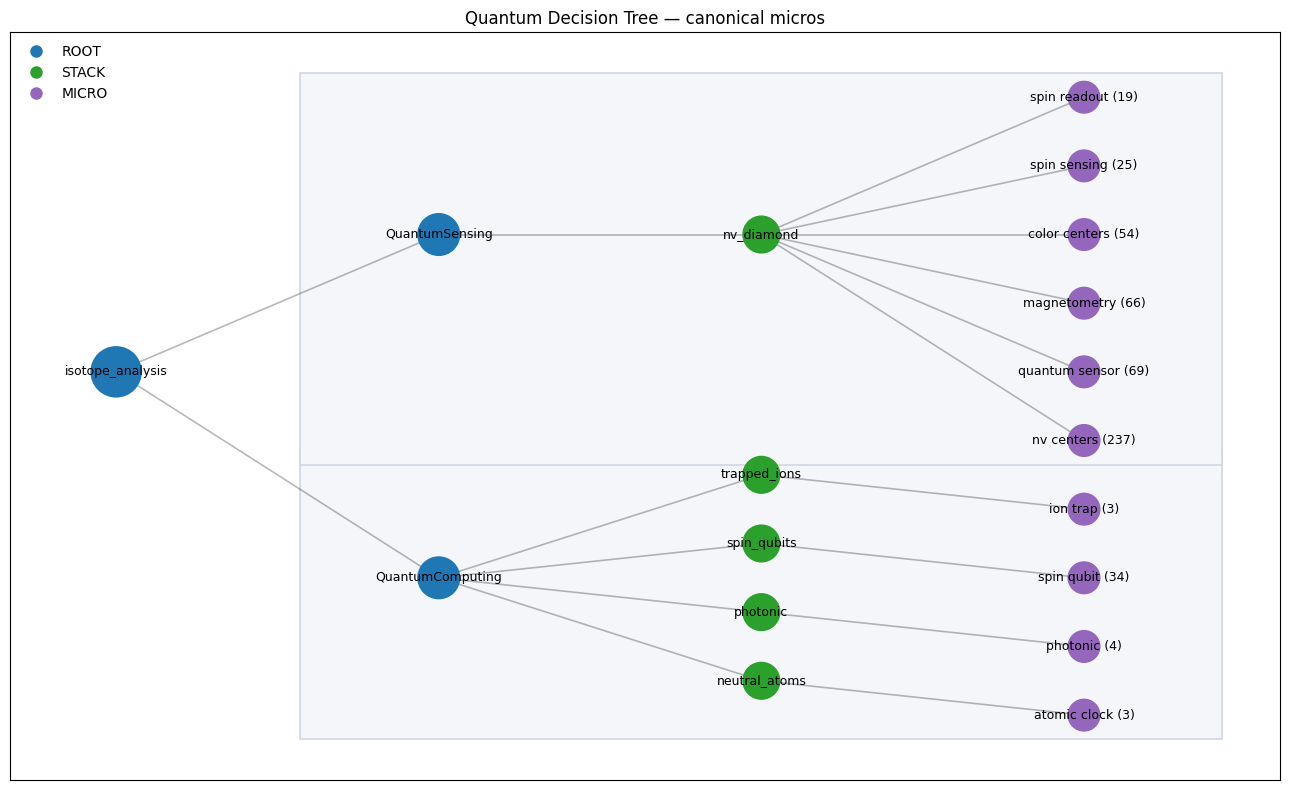

In [2]:
"""
Isotope Decision-Tree Plotter 
----------------------------------------------

Purpose
- Turn the pipeline outputs (nodes/edges + canonical micro labels) into a clean,
  hierarchy-style network plot:
    ROOT → AREA → STACK → MICRO (→ PAPER, optional)

Upstream inputs (produced by your pipeline)
- Isotope_nodes_decision_tree.csv
- Isotope_edges_decision_tree.csv
- One of:
    • Isotope_enriched_papers.csv  (expects column 'MicroCanonical')
    • Isotope_classification_canonical.json

What this script does
- Loads the decision-tree nodes/edges and the canonical micro mapping.
- Optionally filters by area/stack/micro and year.
- Rewires the graph so every STACK fans into its set of canonical MICROS,
  then (optionally) MICROS fan into their PAPERS.
- Excludes "other" stack/micro by default to keep visuals focused.
- Draws a simple, readable hierarchy layout with light grouping boxes.

How to run (typical)
    python isotope_plot.py
    # Ensure the four input files sit next to this script.

Options (edit the parameters section below)
- Focus filters: FOCUS_AREA, FOCUS_STACK, FOCUS_MICRO
- Year range: YEAR_MIN, YEAR_MAX
- SHOW_PAPERS: False (default) shows counts only; True draws individual papers
- SAVE_FIG_PATH: set to e.g. "decision_tree.png" to save a file

"""

import re
import json
import random
from pathlib import Path
from collections import defaultdict

import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D

# ----------------- STRICT I/O: isotope files only -----------------
# These files are created by the upstream pipeline (see docstring).
NODES_CSV = Path("Isotope_nodes_decision_tree.csv")
EDGES_CSV = Path("Isotope_edges_decision_tree.csv")
CANONICAL_CSV  = Path("Isotope_enriched_papers.csv")            # expects 'MicroCanonical'
CANONICAL_JSON = Path("Isotope_classification_canonical.json")  # alternative to CSV

# Check the required files early with a helpful error.
missing = []
for p, name in [
    (NODES_CSV, "Isotope_nodes_decision_tree.csv"),
    (EDGES_CSV, "Isotope_edges_decision_tree.csv"),
]:
    if not p.exists():
        missing.append(name)

if missing:
    raise FileNotFoundError(
        "Path(s) not found (strict mode, no quant_* fallbacks):\n  - "
        + "\n  - ".join(missing)
        + "\nCreate these files first with your pipeline."
    )

if not CANONICAL_CSV.exists() and not CANONICAL_JSON.exists():
    raise FileNotFoundError(
        "No canonical isotope file found.\n"
        "Expect ONE of the following files (isotope naming scheme):\n"
        "  - Isotope_enriched_papers.csv  (with column 'MicroCanonical')\n"
        "  - Isotope_classification_canonical.json"
    )

# ----------------- Parameters (tweak here for your plot) -----------------
# Focus filters (leave as None to plot everything)
FOCUS_AREA   = None     # e.g. "QuantumComputing"
FOCUS_STACK  = None     # e.g. "nv_diamond"
FOCUS_MICRO  = None     # e.g. "magnetometry"

# Year filter (inclusive). Use None to disable a bound.
YEAR_MIN, YEAR_MAX = None, None

# Visual toggles
SHOW_GROUP_BOXES   = True     # light gray backdrop per top subtree
MAX_LABEL_LEN      = 28       # truncate long labels to keep the plot readable
PAPER_JITTER       = 0.15     # vertical jitter for paper nodes (if shown)

# Hide papers by default → show only Area/Stack/Micro with aggregated counts
SHOW_PAPERS          = False
MAX_PAPERS_PER_MICRO = 20     # only relevant if SHOW_PAPERS=True; aggregates the rest
AGGREGATE_REST       = True

# Relationship type not used here (kept for future work)
DRAW_EVOLVES_TO = False

# Exclude "others" by default to keep plots clean
EXCLUDE_OTHER_MICRO = True    # ignore all micro = "other_micro"
EXCLUDE_OTHER_STACK = True    # ignore entire stack = "other"
EXCLUDE_EMPTY_AREAS = True    # remove areas without stacks

# Save the figure if you want a file output; set to e.g. "decision_tree.png"
SAVE_FIG_PATH = None          # or "decision_tree.png" / "decision_tree.svg"

# Colors/Sizes
sizes = {"root":1300, "area":900, "stack":700, "micro":520, "paper":12}
color_map  = {"root":"#1f77b4","area":"#1f77b4","stack":"#2ca02c","micro":"#9467bd","paper":"#7f7f7f"}

def canonical_micro_id(stack_label: str, micro_label: str) -> str:
    """Stable node id for a (stack, canonical micro) pair."""
    sl = re.sub(r"[^a-zA-Z0-9]+", "_", (stack_label or "STACK")).strip("_")
    ml = re.sub(r"[^a-zA-Z0-9]+", "_", (micro_label or "micro")).strip("_")
    return f"MICRO::CANON::{sl}::{ml}"

# ----------------- Load: Nodes/Edges -----------------
nodes_df = pd.read_csv(NODES_CSV)
edges_df = pd.read_csv(EDGES_CSV)

# Helpful lookups
label = dict(zip(nodes_df["id"], nodes_df["label"]))
types = dict(zip(nodes_df["id"], nodes_df["type"]))

def year_map(df: pd.DataFrame):
    """Build a safe id→year mapping (None when year is missing)."""
    y = {}
    for _, r in df.iterrows():
        try:
            y[r["id"]] = int(r.get("year", "")) if str(r.get("year","")).strip() != "" else None
        except Exception:
            y[r["id"]] = None
    return y

years = year_map(nodes_df)

# Build the original directed graph from nodes/edges
G = nx.DiGraph()
for nid in nodes_df["id"]:
    G.add_node(nid)
for _, r in edges_df.iterrows():
    G.add_edge(r["source"], r["target"], etype=r["type"])

# ----------------- Canonical micro mapping (isotope-only) -----------------
# We support either enriched CSV (preferred) or the canonical JSON payload.
paper2canonical, title2canonical = {}, {}

if CANONICAL_CSV.exists():
    cdf = pd.read_csv(CANONICAL_CSV)
    col_id    = next((c for c in ["paper_id","id","openalex_id","node_id"] if c in cdf.columns), None)
    col_title = next((c for c in ["title","display_name"] if c in cdf.columns), None)
    col_canon = next((c for c in ["MicroCanonical","micro_canonical","canonical_micro"] if c in cdf.columns), None)
    if col_canon is None:
        raise ValueError("Isotope_enriched_papers.csv exists but does not contain a 'MicroCanonical' column.")
    if col_id:
        for _, r in cdf.iterrows():
            paper2canonical[str(r[col_id])] = str(r[col_canon]).strip()
    if col_title:
        def norm(s): return re.sub(r"\s+"," ", str(s or "")).strip().lower()[:180]
        for _, r in cdf.iterrows():
            title2canonical[norm(r[col_title])] = str(r[col_canon]).strip()

elif CANONICAL_JSON.exists():
    with open(CANONICAL_JSON, "r", encoding="utf-8") as f:
        data = json.load(f)
    items = data.get("papers", [])
    if not items:
        raise ValueError(f"{CANONICAL_JSON} contains no 'papers' array.")
    for it in items:
        pid = str(it.get("id","")).strip()
        mic = str(it.get("micro_canonical","")).strip()
        if pid:
            paper2canonical[pid] = mic

if not paper2canonical and not title2canonical:
    raise RuntimeError(
        "Could not load canonical micros (isotope-only mode). "
        "Ensure the isotope files are correctly populated."
    )

# ----------------- Focus & year filters -----------------
def ids_by_label(lbl, kind):
    """Find node ids by (label, type) pair."""
    if lbl is None: return set()
    m = (nodes_df["label"].astype(str).str.lower() == str(lbl).lower())
    m &= (nodes_df["type"].astype(str).str.lower() == kind.lower())
    return set(nodes_df.loc[m, "id"].tolist())

focus_ids = set(nodes_df["id"])
sel = set()
if FOCUS_AREA:  sel |= ids_by_label(FOCUS_AREA,  "area")
if FOCUS_STACK: sel |= ids_by_label(FOCUS_STACK, "stack")
if FOCUS_MICRO: sel |= ids_by_label(FOCUS_MICRO, "micro")
if sel:
    # Include ancestors and descendants of any selected node (keeps branches intact)
    anc = set().union(*[nx.ancestors(G, s) | {s} | nx.descendants(G, s) for s in sel])
    focus_ids = anc

def is_paper(n): return types.get(n,"")=="paper"

# Optional year filtering (papers only; structural nodes are always kept)
if YEAR_MIN is not None or YEAR_MAX is not None:
    fil = set()
    for n in focus_ids:
        if not is_paper(n):
            fil.add(n); continue
        y = years.get(n, None)
        if (YEAR_MIN is None or (y is not None and y >= YEAR_MIN)) and \
           (YEAR_MAX is None or (y is not None and y <= YEAR_MAX)):
            fil.add(n)
    focus_ids = fil

# Keep a focused subgraph and its hierarchy edges
H0 = G.subgraph(focus_ids).copy()
hierE0 = [(u,v) for u,v,d in H0.edges(data=True) if d.get("etype")=="HIERARCHY"]

# Parent/child helper maps for ancestor lookups
parent = {}
children0 = defaultdict(list)
for u,v in hierE0:
    parent[v] = u
    children0[u].append(v)

def get_ancestor_of_type(nid, want_type):
    """Climb up the tree until a node of the requested type is found."""
    cur = nid
    visited = set()
    while cur in parent and cur not in visited:
        visited.add(cur)
        cur = parent[cur]
        if types.get(cur) == want_type:
            return cur
    return None

# Title normalization for fallback (when there's no id match)
title_norm = {}
for nid in H0.nodes():
    if types.get(nid)=="paper":
        t = label.get(nid,"")
        t = re.sub(r"\s+"," ", str(t or "")).strip().lower()
        title_norm[nid] = t[:180]

# ----------------- Rewire: STACK → canonical MICRO → PAPER -----------------
# Build a new graph H that excludes "other" by default and aggregates papers if desired.
H = nx.DiGraph()

# Keep structure nodes (root/area/stack), potentially excluding "other" stacks.
for n in H0.nodes():
    if types.get(n) == "stack" and EXCLUDE_OTHER_STACK and str(label.get(n,"")).strip().lower() == "other":
        continue
    if types.get(n) in {"root","area","stack"}:
        H.add_node(n)

# Carry over only structural hierarchy edges
for u,v in hierE0:
    if u in H and v in H and types.get(u) in {"root","area"} and types.get(v) in {"area","stack"}:
        H.add_edge(u,v, etype="HIERARCHY")

def add_micro_node(stack_node_id, canon_micro_label):
    """Create (if needed) and return a canonical micro node under a given stack."""
    stack_lbl = label.get(stack_node_id, "STACK")
    mid = canonical_micro_id(stack_lbl, canon_micro_label)
    if mid not in H:
        H.add_node(mid)
        types[mid] = "micro"
        label[mid] = canon_micro_label
        H.add_edge(stack_node_id, mid, etype="HIERARCHY")
    return mid

paper_nodes = [n for n in H0.nodes() if types.get(n)=="paper"]

for p in paper_nodes:
    stack_node = get_ancestor_of_type(p, "stack") or get_ancestor_of_type(p,"area") or get_ancestor_of_type(p,"root")

    # Skip papers tied to 'other' stacks if we filter stacks
    if EXCLUDE_OTHER_STACK and stack_node and str(label.get(stack_node,"")).strip().lower() == "other":
        continue

    # Map via paper id; fallback to normalized title (if id not aligned)
    canon = paper2canonical.get(p) or title2canonical.get(title_norm.get(p,"")) or "other_micro"

    # Skip other_micro entirely if requested (default = True)
    if EXCLUDE_OTHER_MICRO and canon.strip().lower() == "other_micro":
        continue

    mid = add_micro_node(stack_node, canon)

    if SHOW_PAPERS:
        H.add_node(p)
        H.add_edge(mid, p, etype="HIERARCHY")
    else:
        # Aggregate: track counts on the micro node to annotate labels later
        H.nodes[mid]["_paper_count"] = H.nodes[mid].get("_paper_count", 0) + 1

# ----------------- Prune empty branches (robust cleanup) -----------------
def prune_empty_branches(H, types, label):
    changed = True
    while changed:
        changed = False

        # 1) remove any lingering 'other' stacks
        for n in list(H.nodes()):
            if types.get(n) == "stack" and str(label.get(n,"")).strip().lower() == "other":
                H.remove_node(n)
                changed = True

        # 2) remove stacks without micro children
        for n in list(H.nodes()):
            if types.get(n) == "stack":
                has_micro = any(types.get(c) == "micro" for c in H.successors(n))
                if not has_micro:
                    H.remove_node(n)
                    changed = True

        # 3) remove areas without stack children
        for n in list(H.nodes()):
            if types.get(n) == "area":
                has_stack = any(types.get(c) == "stack" for c in H.successors(n))
                if not has_stack:
                    H.remove_node(n)
                    changed = True
    return H

# Perform cleanup BEFORE we compute final edge lists
H = prune_empty_branches(H, types, label)

# If papers are shown: sort children and aggregate long tails
if SHOW_PAPERS:
    random.seed(42)
    def safe_label(s): return s if isinstance(s,str) else ""
    for m in [n for n in H.nodes() if types.get(n)=="micro"]:
        kids = [c for c in H.successors(m) if types.get(c)=="paper"]
        kids.sort(key=lambda p: ((years.get(p, 10**9) if years.get(p) is not None else 10**9),
                                 safe_label(label.get(p,"")).lower()))
        if MAX_PAPERS_PER_MICRO and len(kids) > MAX_PAPERS_PER_MICRO:
            keep = kids[:MAX_PAPERS_PER_MICRO]
            rest = kids[MAX_PAPERS_PER_MICRO:]
            for r in rest:
                if H.has_edge(m, r):
                    H.remove_edge(m, r)
            agg_id = f"{m}::AGGREGATE::{len(rest)}"
            H.add_node(agg_id)
            types[agg_id] = "paper"
            label[agg_id] = f"+{len(rest)} more"
            years[agg_id] = None
            H.add_edge(m, agg_id, etype="HIERARCHY")

# If papers are hidden: append counts to micro labels
if not SHOW_PAPERS:
    for n in [n for n in H.nodes() if types.get(n)=="micro"]:
        cnt = H.nodes[n].get("_paper_count", 0)
        base = label.get(n, "micro")
        label[n] = f"{base} ({cnt})"

# Final hierarchy edges for drawing
hierE = [(u,v) for u,v in H.edges() if H[u][v].get("etype")=="HIERARCHY"]

# ----------------- Tree structure & sorting -----------------
children = defaultdict(list)
parents  = {}
for u,v in hierE:
    children[u].append(v); parents[v]=u

level_idx = {"root":0, "area":1, "stack":2, "micro":3, "paper":4}
level = {n: level_idx.get(types.get(n,"paper"), 4) for n in H.nodes()}

def micro_count(n):
    # With papers shown, count paper children; otherwise use the aggregated counter.
    return sum(1 for c in children.get(n, []) if types.get(c)=="paper") if SHOW_PAPERS else H.nodes[n].get("_paper_count",0)

# Sort children: papers by year+title; non-papers by descending micro_count then alpha
for n in list(children.keys()):
    if not children[n]: continue
    if all(types.get(c)=="paper" for c in children[n]):
        children[n].sort(key=lambda c: (years.get(c, 0) or 0, (label.get(c,"") or "").lower()))
    else:
        children[n].sort(key=lambda c: (-micro_count(c), (label.get(c,"") or "").lower()))

roots = [n for n in H.nodes() if types.get(n)=="root"]
root = roots[0] if roots else None

# ----------------- Layout (simple recursive column layout) -----------------
x_gap = 1.4; y_gap = 1.0; box_pad = 0.35
pos = {}

def place_subtree(n, x, y_start):
    """Recursively place a node and its subtree, returning the vertical space used."""
    ch = [c for c in children.get(n, []) if c in H]
    if not ch:
        pos[n] = (x, y_start); return y_gap
    heights=[]; y_cursor=y_start
    for c in ch:
        h = place_subtree(c, x + x_gap, y_cursor)
        heights.append(h); y_cursor += h
    total_h = sum(heights) if heights else y_gap
    pos[n] = (x, y_start + total_h/2.0)
    return max(total_h, y_gap)

# Place top-level subtrees (areas) and the root
tops = [t for t in children.get(root, [])] if root else [n for n in H.nodes() if level[n]==1]
tops.sort(key=lambda t: (label.get(t,"") or "").lower())
y_cursor=0.0; x_root=0.0
if root:
    heights=[]
    for t in tops:
        h = place_subtree(t, x_root + x_gap, y_cursor)
        heights.append(h); y_cursor += h
    pos[root]=(x_root, sum(heights)/2.0 if heights else 0.0)
else:
    for t in tops:
        y_cursor += place_subtree(t, 0.0, y_cursor)

# Jitter only for paper nodes (helps overlaps when SHOW_PAPERS=True)
if SHOW_PAPERS:
    for n in H.nodes():
        if types.get(n)=="paper" and n in pos:
            x,y = pos[n]
            pos[n] = (x, y + (random.random()-0.5)*2*PAPER_JITTER)

# ----------------- Draw -----------------
plt.figure(figsize=(13, 8))
ax = plt.gca()

# Optional group boxes around each top-level subtree (usually an AREA)
if SHOW_GROUP_BOXES:
    for t in tops:
        sub_tree = {t}; stack=[t]
        while stack:
            a = stack.pop()
            for c in children.get(a, []):
                if c in H and c not in sub_tree:
                    sub_tree.add(c); stack.append(c)
        if len(sub_tree) > 1 and all(n in pos for n in sub_tree):
            xs = [pos[n][0] for n in sub_tree]
            ys = [pos[n][1] for n in sub_tree]
            x, y = min(xs)-0.6, min(ys)-box_pad
            w, h = (max(xs)-min(xs))+1.2, (max(ys)-min(ys))+2*box_pad
            ax.add_patch(Rectangle((x, y), w, h, facecolor="#f4f6fa", edgecolor="#d0d7e2", linewidth=1.2, zorder=0))

def node_size(n): return sizes.get(types.get(n,"paper"), 80)
node_sizes = [node_size(n) for n in H.nodes()]
node_colors = [color_map.get(types.get(n,"paper"), "#999999") for n in H.nodes()]

nx.draw_networkx_edges(H, pos, edgelist=hierE, arrows=False, alpha=0.28, width=1.2)
nx.draw_networkx_nodes(H, pos, node_size=node_sizes, node_color=node_colors)

# Labels: show for structure nodes; also show aggregate pseudo-papers
labels = {}
for n in H.nodes():
    t = types.get(n)
    if t in {"root","area","stack","micro"} or (SHOW_PAPERS and "::AGGREGATE::" in str(n)):
        txt = label.get(n, n)
        labels[n] = (txt if len(txt) <= MAX_LABEL_LEN else txt[:MAX_LABEL_LEN-1] + "…")
nx.draw_networkx_labels(H, pos, labels=labels, font_size=9)

# Simple legend
legend_elems = [
    Line2D([0],[0], marker='o', color='w', label='ROOT',  markerfacecolor=color_map["area"],  markersize=10),
    Line2D([0],[0], marker='o', color='w', label='STACK', markerfacecolor=color_map["stack"], markersize=10),
    Line2D([0],[0], marker='o', color='w', label='MICRO', markerfacecolor=color_map["micro"], markersize=10),
]
if SHOW_PAPERS:
    legend_elems.append(Line2D([0],[0], marker='o', color='w', label='Paper', markerfacecolor=color_map["paper"], markersize=10))
plt.legend(handles=legend_elems, loc="upper left", frameon=False)

plt.title("Quantum Decision Tree — canonical micros")
plt.tight_layout()

# Save to file if requested; otherwise show interactively.
if SAVE_FIG_PATH:
    plt.savefig(SAVE_FIG_PATH, dpi=200, bbox_inches="tight")
else:
    plt.show()


